# Textual Inversion

This notebook generates images from the trained textual inversion models, saved as Determined checkpoints.  This notebook should be connected to a GPU.

Start with installs and imports:

In [1]:
! pip install -Uqq diffusers["training"]==0.2.4 transformers==4.21.3 ftfy==6.1.1 setuptools==59.5.0 jupyterlab-widgets==1.1.1 ipywidgets==7.7.2

In [2]:
import json
import os
import pathlib
import PIL
from datetime import datetime
from IPython import display
from typing import List, Optional

import torch
from determined.experimental import client
from diffusers import (
    AutoencoderKL,
    DDPMScheduler,
    DDIMScheduler,
    LMSDiscreteScheduler,
    PNDMScheduler,
    StableDiffusionPipeline,
    UNet2DConditionModel,
)
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer

A [Huggingface User Access Token](https://huggingface.co/docs/hub/security-tokens) is required to download the [Stable Diffusion weights](https://huggingface.co/CompVis/stable-diffusion-v1-4):

In [3]:
HF_AUTH_TOKEN = YOUR_HF_AUTH_TOKEN_HERE

## Download the Determined Checkpoint

Download the saved Determined checkpoint by uuid and inspect:

In [4]:
# Not necessary if already logged into the cluster.
# client.login(master: MASTER_URL, user: USER, password: PASS)

In [5]:
CHECKPOINT_UUID = YOUR_CHECKPOINT_UUID_HERE
checkpoint = client.get_checkpoint(CHECKPOINT_UUID)
checkpoint_path = pathlib.Path(checkpoint.download())
checkpoint_subdirs = os.listdir(checkpoint_path)
checkpoint_subdirs

['metadata.json',
 'generated_imgs.pt',
 'imgs',
 'learned_embeds.pt',
 'optimizer_state_dict.pt']

If the `generate_training_images` flag was set to `True` (the default) during training generated during training are saved in the checkpoint directory under `/imgs`. Included images:
* All generated images, labeled by step created
* All images concatenated left-to-right into `all_imgs.png`
* All images turned into a gif: `all_imgs.gif`

Inspect a concatenated image, which should demonstrate the process of learning about the provided concept.

Showing all images from the prompt "a photo of a <cat-toy>"


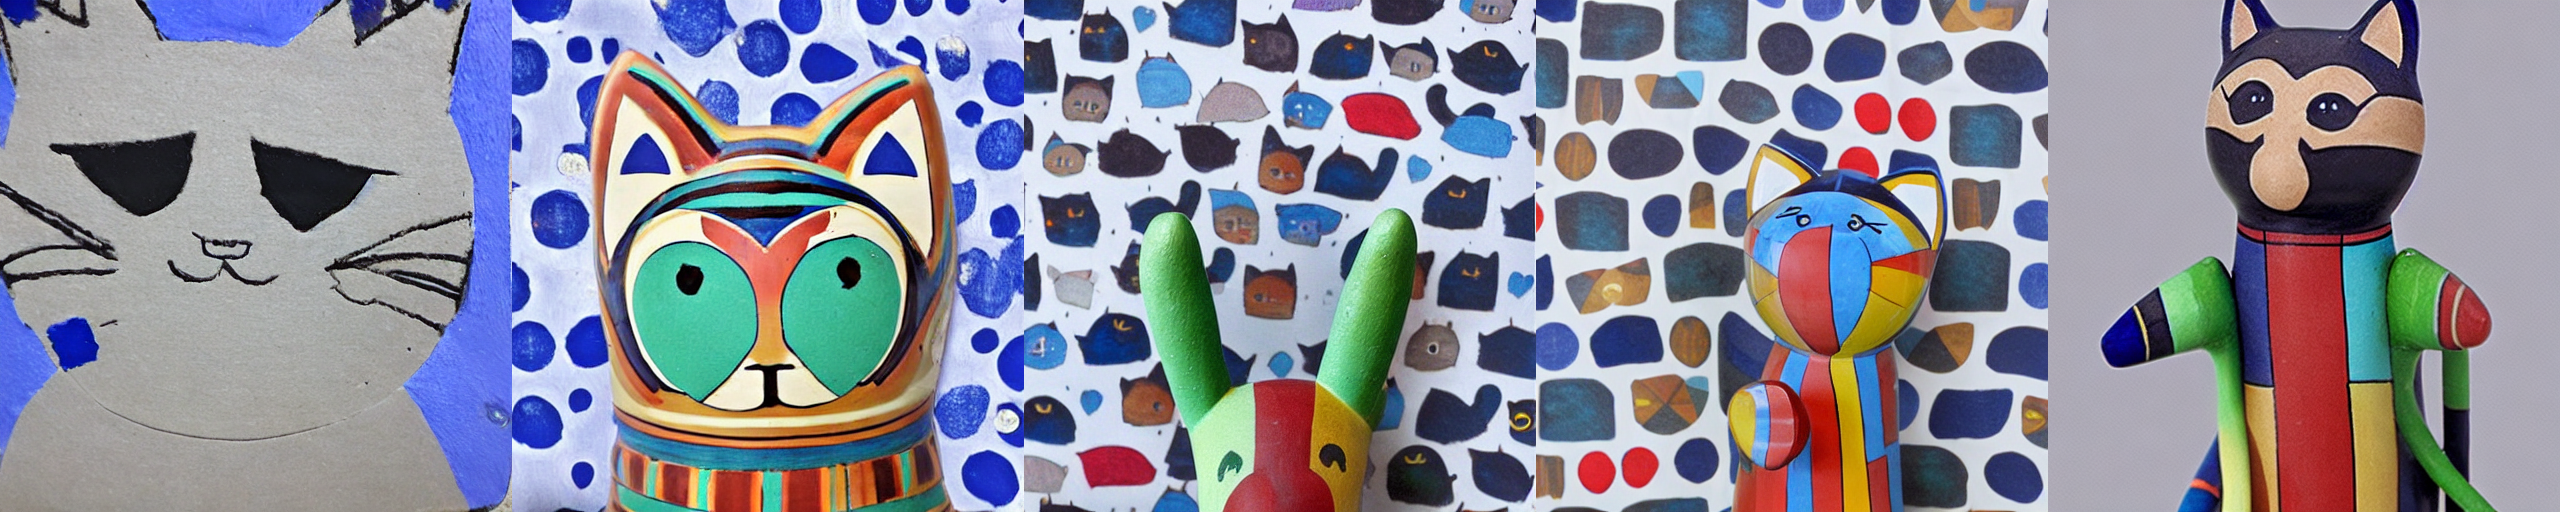

In [6]:
imgs_path = pathlib.Path(checkpoint_path).joinpath('imgs')
first_subdir = imgs_path.joinpath(os.listdir(imgs_path)[0])
print(f'Showing all images from the prompt "{" ".join(first_subdir.stem.split("_"))}"')
PIL.Image.open(first_subdir.joinpath('all_imgs.png'))

## Building the Pipeline

View the checkpoint metadata.  Parts of this dictionary will be used to construct the `StableDiffusionPipeline`:

In [7]:
with open(checkpoint_path.joinpath('metadata.json'), 'r') as f:
    checkpoint_metadata_dict = json.load(f)
checkpoint_metadata_dict

{'steps_completed': 250,
 'initializer_tokens': ['cat'],
 'placeholder_tokens': ['<cat-toy>'],
 'placeholder_token_ids': [49408],
 'pretrained_model_name_or_path': 'CompVis/stable-diffusion-v1-4',
 'inference_noise_scheduler_name': 'pndm',
 'inference_noise_scheduler_kwargs': {'beta_start': 0.00085,
  'beta_end': 0.012,
  'beta_schedule': 'scaled_linear',
  'skip_prk_steps': True}}

And load the new, trained concept embeddings:

In [8]:
learned_embeds_dict = torch.load(checkpoint_path.joinpath('learned_embeds.pt'))

Build the stable diffusion pipeline and generate images.

In [9]:
def build_pipeline(checkpoint_path: str = checkpoint_path,
                   learned_embeds_filename: str = 'learned_embeds.pt',
                   checkpoint_metadata_dict: dict = checkpoint_metadata_dict, 
                   use_auth_token: str = HF_AUTH_TOKEN,
                   device: str = 'cuda'):
    
    # Download pre-trained models
    pretrained_model_name_or_path = checkpoint_metadata_dict['pretrained_model_name_or_path']
    tokenizer = CLIPTokenizer.from_pretrained(pretrained_model_name_or_path=pretrained_model_name_or_path,
                                          subfolder="tokenizer",
                                          use_auth_token=use_auth_token,
            )
    text_encoder = CLIPTextModel.from_pretrained(
        pretrained_model_name_or_path=pretrained_model_name_or_path,
        subfolder="text_encoder",
        use_auth_token=use_auth_token,
    )
    vae = AutoencoderKL.from_pretrained(
        pretrained_model_name_or_path=pretrained_model_name_or_path,
        subfolder="vae",
        use_auth_token=use_auth_token,
    )
    unet = UNet2DConditionModel.from_pretrained(
        pretrained_model_name_or_path=pretrained_model_name_or_path,
        subfolder="unet",
        use_auth_token=use_auth_token,
    )
    safety_checker = StableDiffusionSafetyChecker.from_pretrained(
        pretrained_model_name_or_path="CompVis/stable-diffusion-safety-checker"
    )
    feature_extractor = CLIPFeatureExtractor.from_pretrained(
        pretrained_model_name_or_path="openai/clip-vit-base-patch32"
    )
    
    # Construct the noise scheduler:
    inference_noise_schedulers = {
            "ddim": DDIMScheduler,
            "lms-discrete": LMSDiscreteScheduler,
            "pndm": PNDMScheduler,
        }
    scheduler_name = checkpoint_metadata_dict['inference_noise_scheduler_name']
    scheduler_kwargs = checkpoint_metadata_dict['inference_noise_scheduler_kwargs']
    scheduler = inference_noise_schedulers[scheduler_name](**scheduler_kwargs)
    
    # Incorporate newly learned concepts into the text_encoder
    placeholder_tokens = checkpoint_metadata_dict['placeholder_tokens']
    learned_embeds_dict = torch.load(checkpoint_path.joinpath(learned_embeds_filename))
    for token in placeholder_tokens:
        tokenizer.add_tokens(token)
    text_encoder.resize_token_embeddings(len(tokenizer))
    token_embeds = text_encoder.get_input_embeddings().weight.data
    for idx, tensor in learned_embeds_dict.items():
        token_embeds[idx] = tensor
            
    # Build and return the pipeline   
    pipeline = StableDiffusionPipeline(
                text_encoder=text_encoder,
                vae=vae,
                unet=unet,
                tokenizer=tokenizer,
                scheduler=scheduler,
                safety_checker=safety_checker,
                feature_extractor=feature_extractor,
            ).to(device)
    
    return pipeline

In [10]:
pipeline = build_pipeline()

Create a helper function to generate and (optionally) save images.

In [46]:
def get_image_grid_from_prompt(prompt: str,
                               rows: int = 1,
                               cols: int = 1,
                               num_inference_steps: int = 50,
                               guidance_scale: int = 7.5,
                               saved_img_dir: Optional[str] = None,
                               generator: Optional[torch.Generator] = None,
                               other_pipeline_call_kwargs: Optional[dict] = None):
    """Generates an image from the provided prompt and optionally writes the results to disk."""
    other_pipeline_call_kwargs = other_pipeline_call_kwargs or {}
    num_samples = rows * cols
    # Generate images sequentially, as parallel computation may induce OOM
    images = []
    generated_samples = 0
    while generated_samples < num_samples:
        out = pipeline(prompt,
                   num_inference_steps=num_inference_steps, 
                   guidance_scale=guidance_scale, 
                   generator=generator,
                   **other_pipeline_call_kwargs)
        # Re-try, if nsfw_content_detected
        if out['nsfw_content_detected'][0]:
            continue
        image = out['sample'][0]
        images.append(image)
        if saved_img_dir is not None:
            time = datetime.now().strftime("%c")
            file_suffix = f'_{time}.png'
            filename = prompt[:128 - len(file_suffix)] + file_suffix
            filename = '_'.join(filename.split())
            save_image(image, filename[-128:], saved_img_dir)
        generated_samples += 1
    tiled_image = create_image_grid(images, rows, cols)
    if num_samples > 1 and saved_img_dir is not None:
        # TODO: Clean up repeated code
        time = datetime.now().strftime("%c")
        file_suffix = f'_{time}_ALL.png'
        filename = prompt[:128 - len(file_suffix)] + file_suffix
        filename = '_'.join(filename.split())
        save_image(tiled_image, filename[-128:], saved_img_dir)
    return tiled_image

def create_image_grid(images: List[PIL.Image.Image], rows: int, cols: int):
    w, h = images[0].size
    image_grid = PIL.Image.new('RGB', size=(cols * w, rows * h))
    for idx, img in enumerate(images):
        image_grid.paste(img, box=(idx % cols * w, idx // cols * h))
    return image_grid

def save_image(image: PIL.Image.Image, filename: str, saved_img_dir: str):
    """Saves the image as a time-stamped png file.
    """
    saved_img_dir = pathlib.Path(saved_img_dir)
    save_path = saved_img_dir.joinpath(filename)
    image.save(save_path)     

The most important, basic arguments are those listed:
* `prompt`: the prompt string which will be used to generate images
* `num_inference_steps`: how many steps to run the generation process for. ~50 is typical
* `guidance_scale`: knob for tuning how much weight is given to the prompt during generation. 7.5 is the default, with larger numbers giving stronger weight to the prompt.

See the [Hugging Face documentation](https://huggingface.co/docs/diffusers/main/en/api/pipelines/stable_diffusion#diffusers.StableDiffusionPipeline.__call__) for more on the available arguments.

In [47]:
placeholder_tokens = checkpoint_metadata_dict['placeholder_tokens']
prompt = f"a painting of {placeholder_tokens[0]} on the moon, stars, outer space, trending on artstation, incredible composition"
num_inference_steps = 50
guidance_scale =12.5

Create images! A fixed `generator` is used for reproducibility.  Fiddle with the seed for additional variation.

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

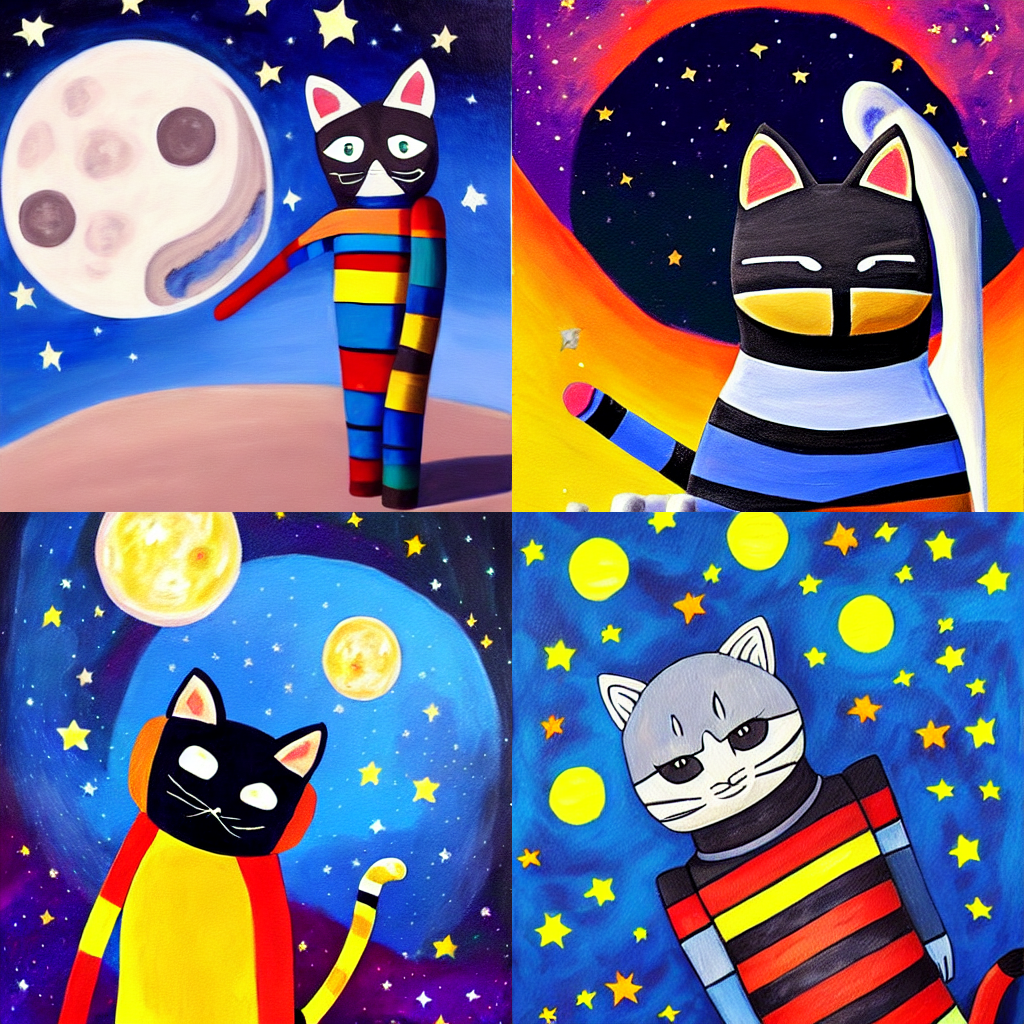

In [48]:
generator = torch.Generator(device='cuda').manual_seed(2147483647)
image_grid = get_image_grid_from_prompt(prompt,
                                        rows=2,
                                        cols=2,
                                        num_inference_steps=num_inference_steps,
                                        generator=generator,
                                        guidance_scale=guidance_scale,
                                        saved_img_dir='generated_images')
image_grid